# Decision Tree Notebook


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import os

In [2]:
# Load the dataset
student_df = pd.read_csv(r'C:\Users\aryan\Desktop\XAI\XAI_Models\multiclass\student_performance\Student_performance_data _.csv')

# Display the first few rows of the dataframe
print(student_df.head())
student_df.head(5)

   StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
0       1001   17       1          0                  2        19.833723   
1       1002   18       0          0                  1        15.408756   
2       1003   15       0          2                  3         4.210570   
3       1004   17       1          0                  3        10.028829   
4       1005   17       1          0                  2         4.672495   

   Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
0         7         1                2                0       0      1   
1         0         0                1                0       0      0   
2        26         0                2                0       0      0   
3        14         0                3                1       0      0   
4        17         1                3                0       0      0   

   Volunteering       GPA  GradeClass  
0             0  2.929196         2.0  
1             0  3

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


         StudentID          Age       Gender    Ethnicity  ParentalEducation  \
count  2392.000000  2392.000000  2392.000000  2392.000000        2392.000000   
mean   2196.500000    16.468645     0.510870     0.877508           1.746237   
std     690.655244     1.123798     0.499986     1.028476           1.000411   
min    1001.000000    15.000000     0.000000     0.000000           0.000000   
25%    1598.750000    15.000000     0.000000     0.000000           1.000000   
50%    2196.500000    16.000000     1.000000     0.000000           2.000000   
75%    2794.250000    17.000000     1.000000     2.000000           2.000000   
max    3392.000000    18.000000     1.000000     3.000000           4.000000   

       StudyTimeWeekly     Absences     Tutoring  ParentalSupport  \
count      2392.000000  2392.000000  2392.000000      2392.000000   
mean          9.771992    14.541388     0.301421         2.122074   
std           5.652774     8.467417     0.458971         1.122813   
min

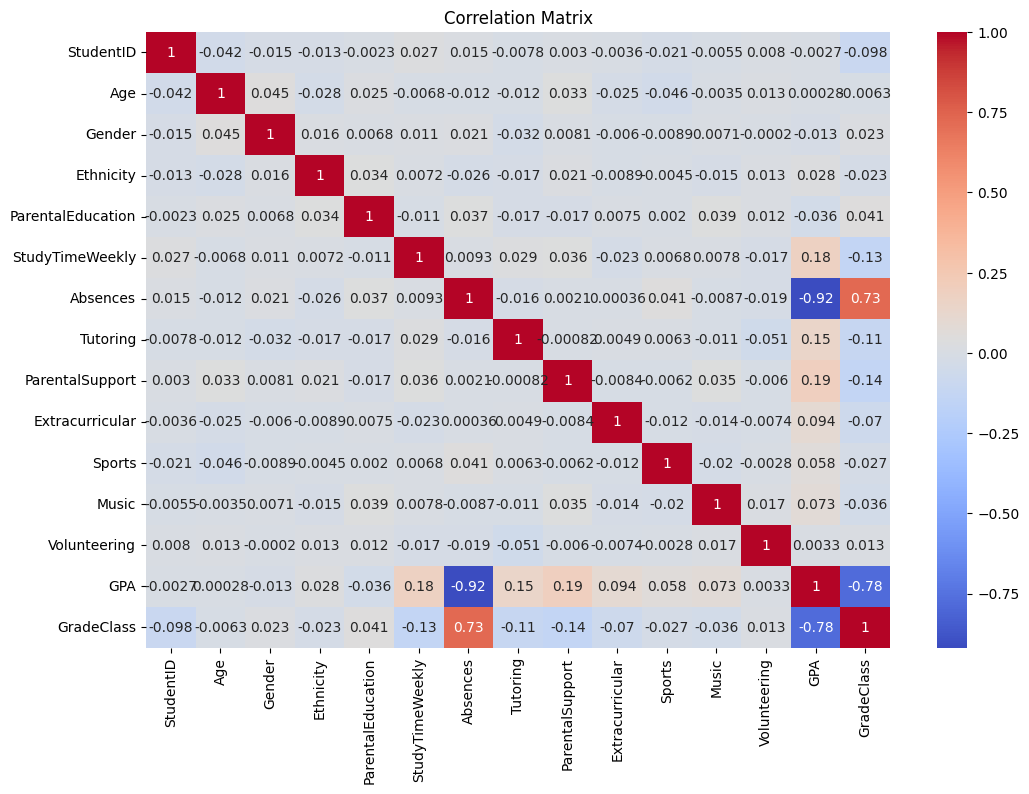

In [3]:
# Display basic statistics
print(student_df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = student_df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

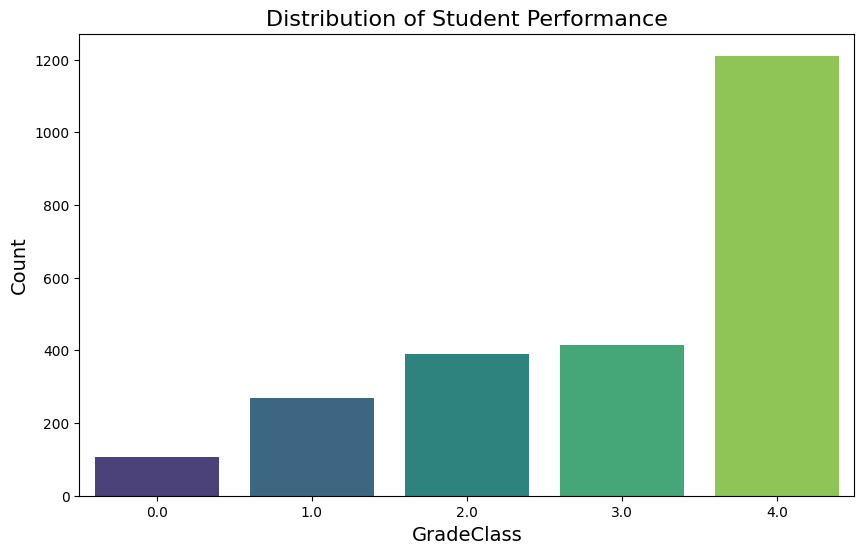

In [4]:
# Distribution of glass types
plt.figure(figsize=(10, 6))
sns.countplot(x='GradeClass', data=student_df, palette='viridis')
plt.title('Distribution of Student Performance', fontsize=16)
plt.xlabel('GradeClass', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


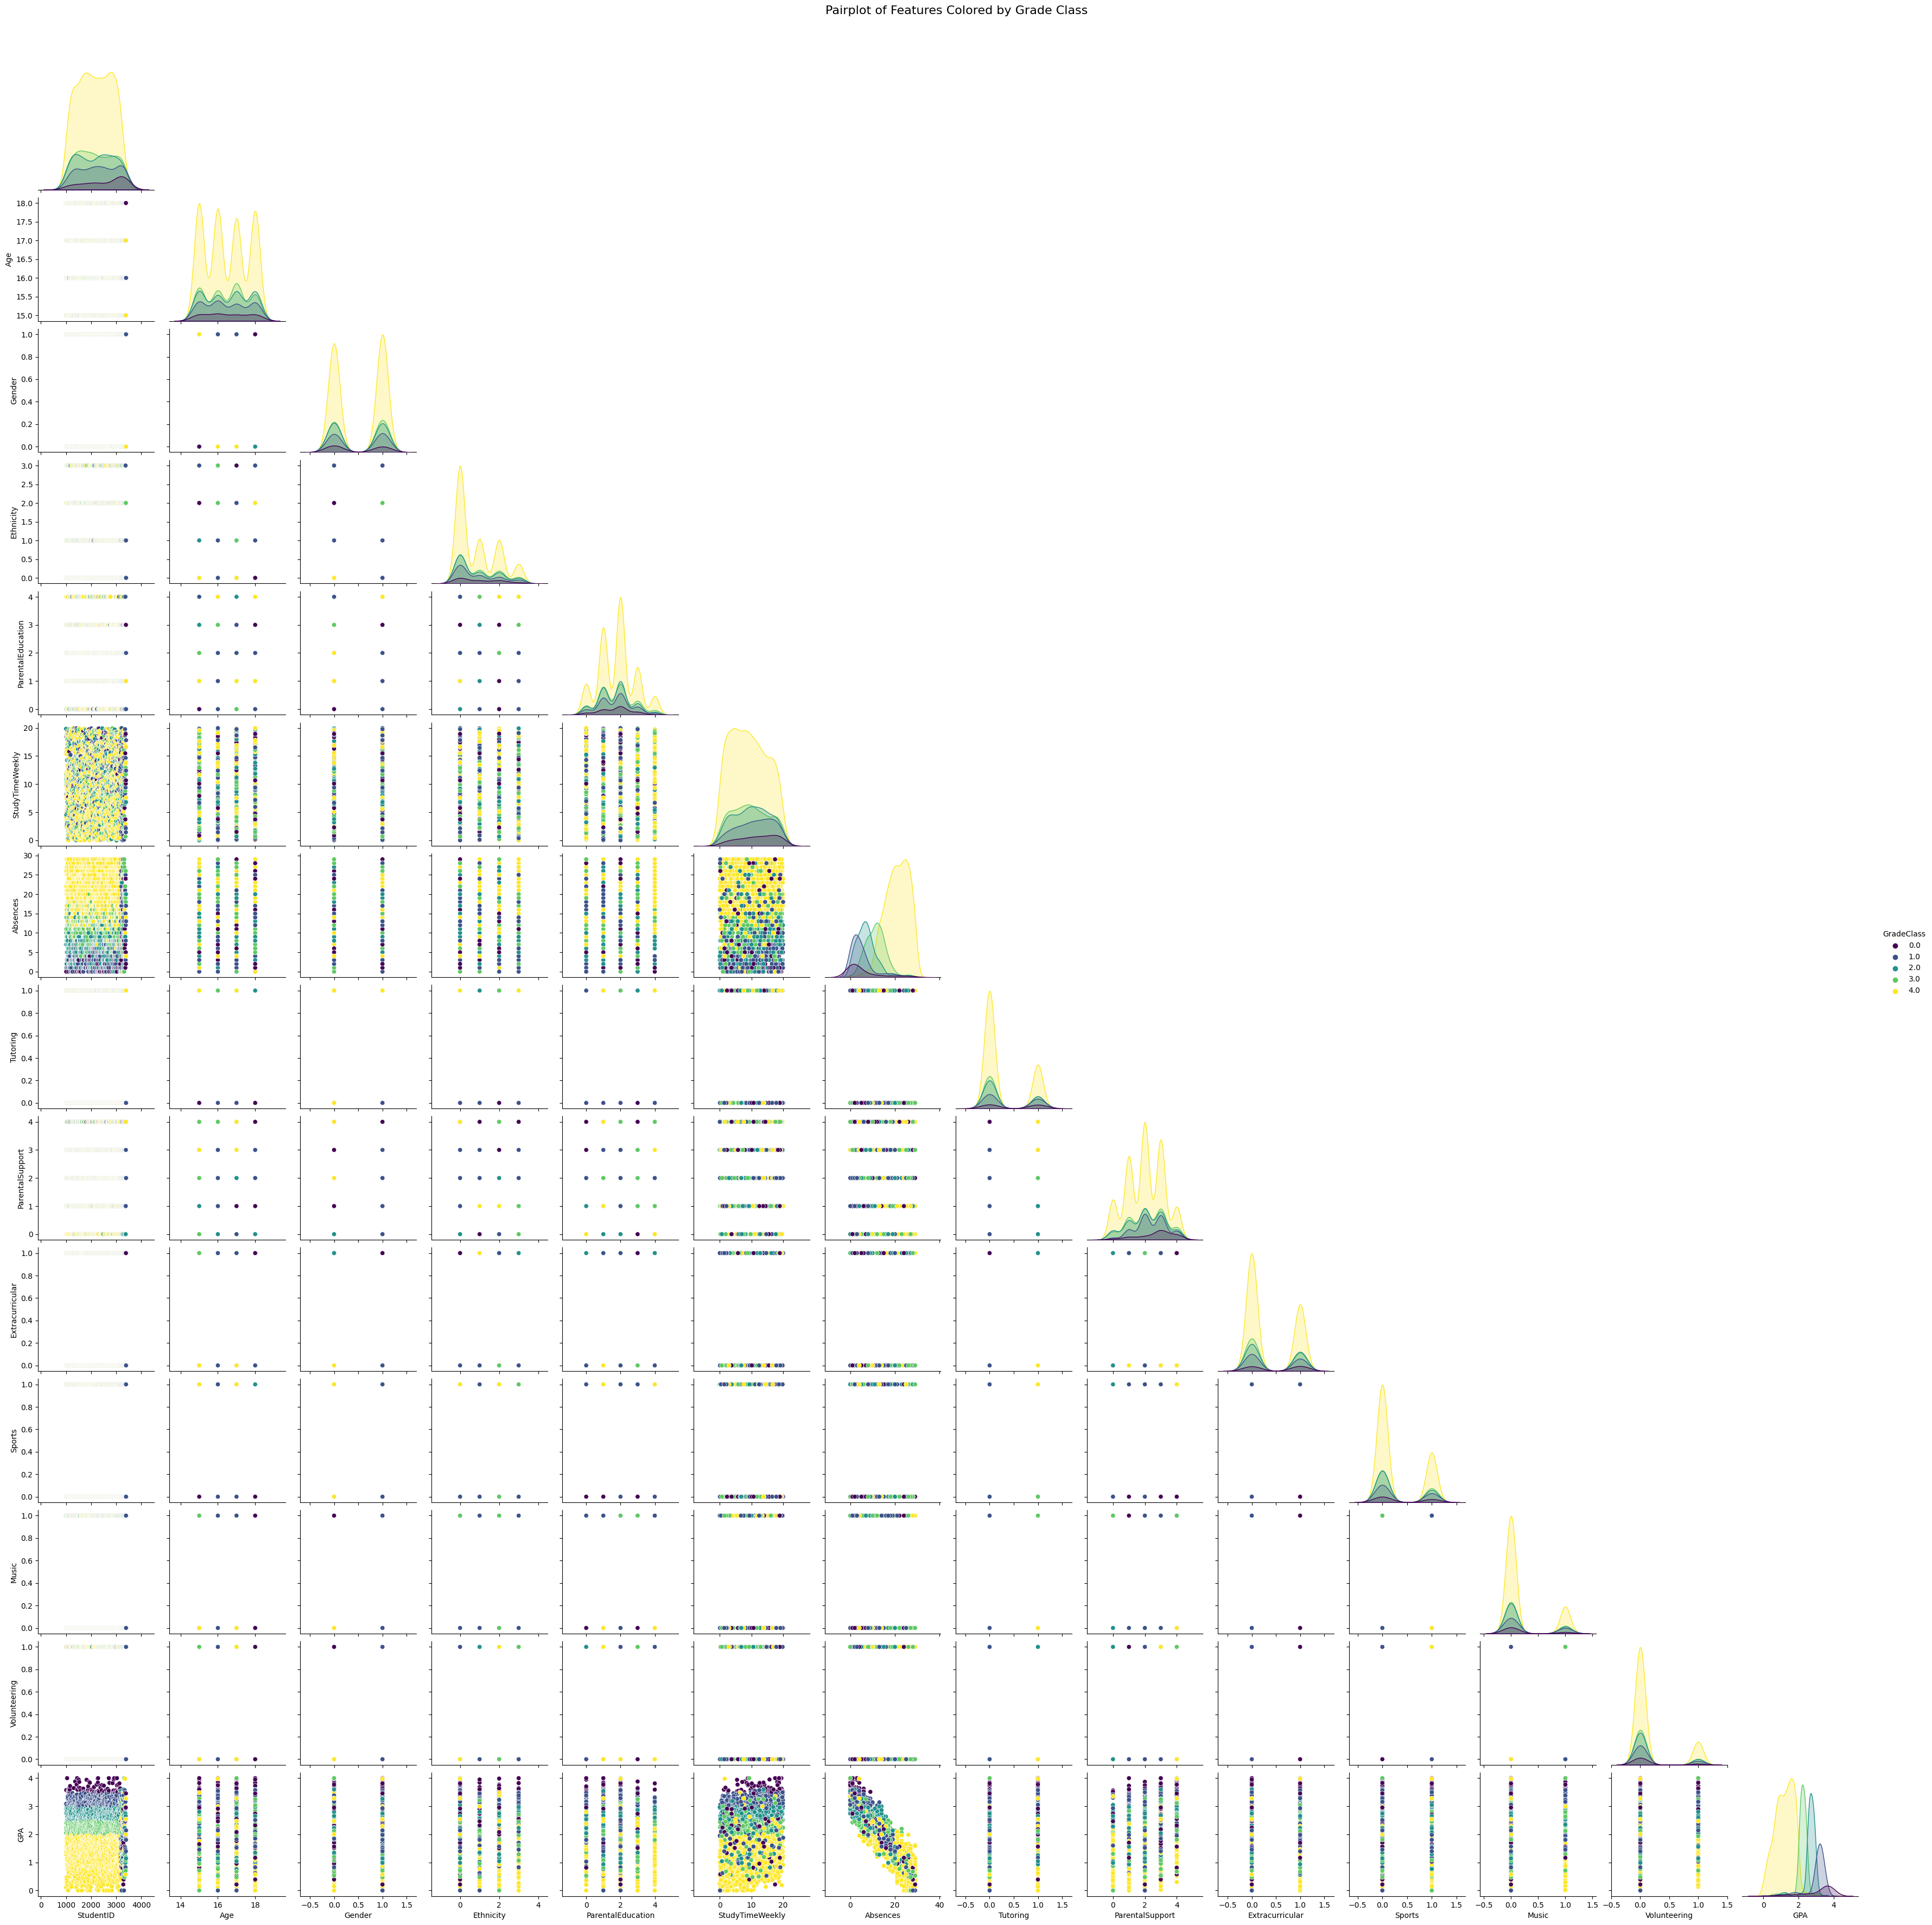

In [5]:
# Pairplot
sns.pairplot(student_df, hue='GradeClass', palette='viridis', corner=True)
plt.suptitle('Pairplot of Features Colored by Grade Class', y=1.02, fontsize=16)
plt.show()

In [6]:

# Define the target and features
X = student_df.drop(columns=['GradeClass'])
y = student_df['GradeClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:

# Define the preprocessor
numerical_features = student_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = student_df.select_dtypes(include=['object']).columns.tolist()
numerical_features.remove('GradeClass')  # Remove the target column

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    # Create the model with the suggested hyperparameters
    dt_classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', dt_classifier)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
    return scores.mean()


In [ ]:
# Check if the hyperparameters are already stored in the JSON file

model_name = 'Decision Tree'
json_file = f'{model_name}.json'

if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        best_params = json.load(file)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Remove the 'model' key from best_params if it exists
best_params.pop('model', None)

# Create the model with the best hyperparameters
dt_classifier = DecisionTreeClassifier(**best_params)

# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)
# Check if the JSON file contains hyperparameters
if 'criterion' in best_params:
    # Use the hyperparameters from the JSON file
    dt_classifier = DecisionTreeClassifier(**best_params)
else:
    # Optimize the hyperparameters using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params

    # Save the best hyperparameters to the JSON file
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

    # Create the model with the best hyperparameters
    dt_classifier = DecisionTreeClassifier(**best_params)
    

Best Hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 38, 'min_samples_split': 9, 'min_samples_leaf': 4}


In [10]:
# Create the pipeline with the best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_classifier)
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['StudentID', 'Age', 'Gender',
                                                   'Ethnicity',
                                                   'ParentalEducation',
                                                   'StudyTimeWeekly',
                                                   'Absences', 'Tutoring',
                                                   'ParentalSupport',
                                                   'Extracurricular', 'Sports',
                                                   'Music', 'Volunteering',
                                                   'GPA']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=38, min_samples_leaf=4,
                                        min_samples_split=9))])

In [11]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.95300261 0.93472585 0.92950392 0.94240838 0.90575916]
Mean cross-validation score: 0.9330799830492257


In [12]:
# Predict on the test data
y_test_pred = pipeline.predict(X_test)

In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, mean_absolute_error
)
from sklearn.preprocessing import LabelEncoder

# Encode the labels to numerical values
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_pred_encoded = label_encoder.transform(y_test_pred)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Classification metrics
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Regression metrics
r2 = r2_score(y_test_encoded, y_test_pred_encoded)
mae = mean_absolute_error(y_test_encoded, y_test_pred_encoded)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


Test Accuracy: 0.918580375782881
Precision: 0.9201862537133725
Recall: 0.918580375782881
F1 Score: 0.9189938068334655
R2 Score: 0.736887362747974
Mean Absolute Error (MAE): 0.16075156576200417


In [14]:
# Generate classification report for the test set
test_report = classification_report(y_test, y_test_pred)
print("Test Classification Report:\n", test_report)

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.57      0.59        21
         1.0       0.81      0.87      0.84        54
         2.0       0.88      0.94      0.91        78
         3.0       0.93      0.92      0.92        83
         4.0       0.98      0.95      0.97       243

    accuracy                           0.92       479
   macro avg       0.84      0.85      0.84       479
weighted avg       0.92      0.92      0.92       479



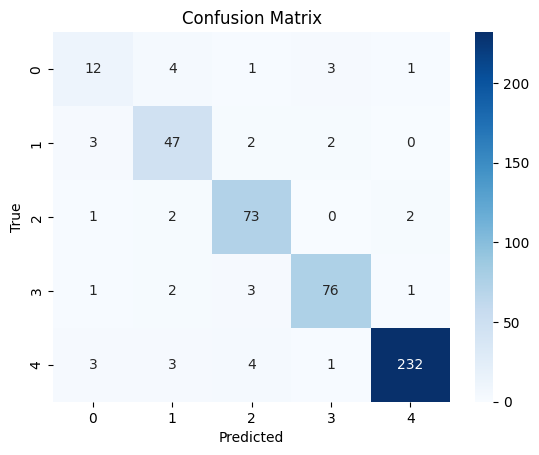

In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

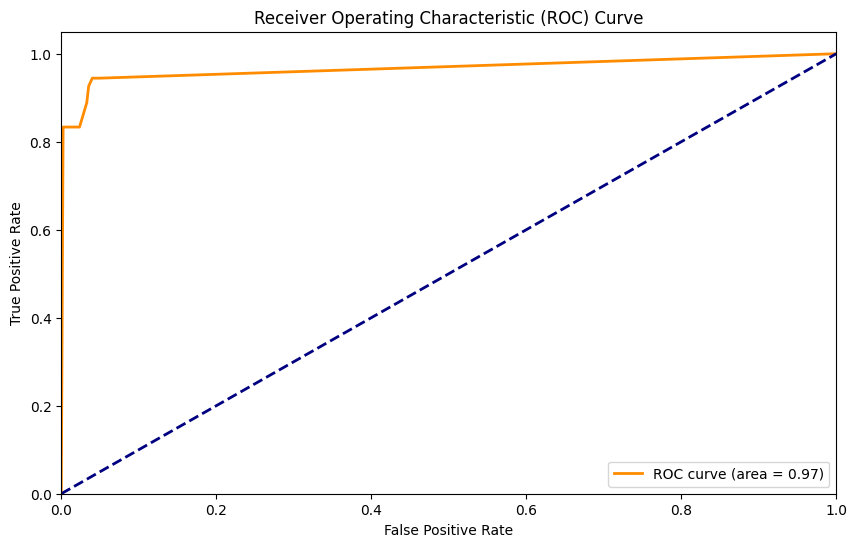

Fidelity: 0.918580375782881


c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


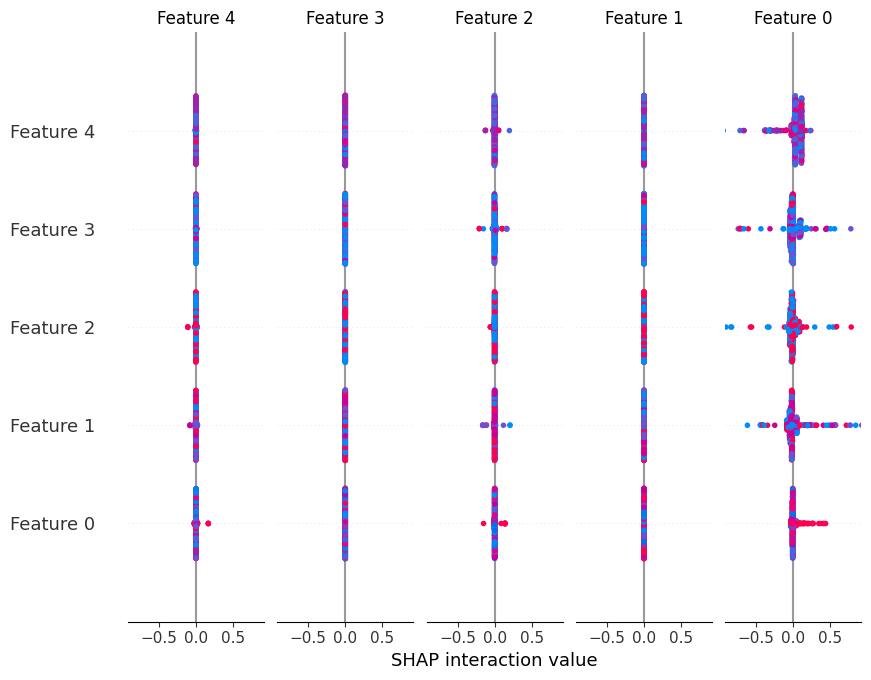

In [16]:
import shap
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Transform X_test using the preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Calculate SHAP values
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(X_test_transformed)

# Plot ROC-AUC curve
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Calculate fidelity
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)

# Explainability using SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed)

In [17]:
from treeinterpreter import treeinterpreter as ti
import pandas as pd

# Get predictions, biases, and contributions
predictions, biases, contributions = ti.predict(dt_classifier, X_test_transformed)

# Select contributions for the positive class (>50K)
positive_class_index = 1  # Index of the positive class
contributions_positive_class = contributions[:, :, positive_class_index]

# Convert contributions into a DataFrame
feature_names = preprocessor.get_feature_names_out()
contributions_df = pd.DataFrame(contributions_positive_class, columns=feature_names)

# Display contributions for the first instance
instance_index = 0
print(f"Feature contributions for instance {instance_index}:")
print(contributions_df.iloc[instance_index])

# Fidelity remains the same
y_test_pred = pipeline.predict(X_test)
fidelity = accuracy_score(y_test, y_test_pred)
print("Fidelity:", fidelity)


Feature contributions for instance 0:
num__StudentID           -0.024414
num__Age                  0.000000
num__Gender               0.000000
num__Ethnicity            0.000000
num__ParentalEducation    0.000000
num__StudyTimeWeekly      0.000000
num__Absences             0.000000
num__Tutoring             0.000000
num__ParentalSupport      0.000000
num__Extracurricular      0.000000
num__Sports               0.000000
num__Music                0.000000
num__Volunteering         0.000000
num__GPA                 -0.087975
Name: 0, dtype: float64
Fidelity: 0.918580375782881


In [18]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "Accuracy": test_accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC-AUC": roc_auc,
    "Fidelity": fidelity,
    "R2_Score": r2,
    "Mean Absolute Error": mae
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("decision_tree_metrics.csv", index=False)

In [19]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(dt_classifier, 'decision_tree.pkl')

print("Model saved successfully as 'decision_tree.pkl'")


Model saved successfully as 'decision_tree.pkl'
